**Purpose**

The purpose of this notebook is to graph growth data from testing sensitivity of different bacteria to sodium hypophosphite.

In [1]:
from elliot_utils import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
analysisPath = Path.cwd().joinpath('analysis_files/hypophosphite_growth/')
figurePath = Path.cwd().joinpath('figures/hypophosphite_growth/') 

In [3]:
# Function to convert growth curve data from a .csv file into a pandas dataframe for processing/graphing
# Returns: A pandas dataframe with headers 'Strain', 'Treatment', 'OD600', 'Hours'
# dataDF: The Dataframe generated by pd.read_csv() of a .csv file with growth curve data in it.
#       This function expects that data to have headers: "Hours", "A1", "A2", etc. The "Hours" header is required.
# strainLocs: A 2D list in the format list[row][column] representing what strains were in what wells of the 96 well plate. Empty wells must have an empty string.
# treatmentLocs: A 2D list in the format list[row][column] representing what treatments were in what wells of the 96 well plate. Empty wells must have an empty string.
def curveData2df(dataDF, strainLocs, treatmentLocs):
    dataDict = {'Strain':[], 'Hypophosphite':[], 'OD600':[], 'Hours':[]}
    hrs = []
    for x in dataDF['Hours']:
        hrs.append(x)
    letterIndex = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7}
    for k in dataDF.keys():
        if k == 'Hours':
            continue
        rowVal = letterIndex[k[0]]
        colVal = int(k[1:]) - 1
        strain = strainLocs[rowVal][colVal]
        treatment = treatmentLocs[rowVal][colVal]
        for i in range(len(dataDF[k])):
            dataDict['OD600'].append(dataDF[k][i])
            dataDict['Hours'].append(hrs[i])
            dataDict['Strain'].append(strain)
            dataDict['Hypophosphite'].append(treatment)
    return pd.DataFrame(dataDict)

# Returns: The dataDF appended with a new column representing the OD600 for the sample at the given time minus its starting OD600
# dataDF: Dataframe output by the curveData2df function
def calculateDeltaOD(dataDF):
    startingOD = None
    deltaODs = []
    for index, row in dataDF.iterrows():
        if row['Hours'] == 0:
            startingOD = row['OD600']
            deltaODs.append(0)
        else:
            deltaODs.append(row['OD600'] - startingOD)
    dataDF['Delta OD600'] = deltaODs

# Returns: A subset DataFrame of "df" with only data for the specified strains and treatments
# df: A DataFrame generated by the curveData2df function. It will have the headers 'Treatment', 'OD600', 'Hours'
# keys: A list of all the keys to select on
# values: A list of lists where values[n] is a list of all the values to include for keys[n]
# If time limit is set, will only return up to the given time point in hours (inclusive)
# If treatments is set to a list, will only return values for those treatments
def sliceDFBy(df, keys, values, timeLimit=1000000000000):
    dataDict = {}
    for key in df.keys():
        dataDict[key] = []
    for index, row in df.iterrows():
        include = True
        for k in keys:
            keyIndex = keys.index(k)
            if not row[k] in values[keyIndex]:
                include = False
        if include:
            for key in dataDict.keys():
                dataDict[key].append(row[key])
    return pd.DataFrame(dataDict)

# Returns the data for each replicate at the given timepoint
def getEndpointData(df, timepoint):
    dataDict = {}
    for key in df.keys():
        dataDict[key] = []
    for index, row in df.iterrows():
        if row['Hours'] == timepoint:
            for key in dataDict.keys():
                dataDict[key].append(row[key])
    return pd.DataFrame(dataDict)

# Object to hold endpoint data values and return them as a normalized percentage of growth on glucose
class GrowthDataHolder:
    def __init__(self):
        self.data = {} #key=strain, value=dict in the format {'treatment':list of delta ODs at 72hrs}
    
    # Add a deltaOD for the specified treatment
    def addData(self, strain, treatment, value):
        if not strain in self.data.keys():
            self.data[strain] = {}
        if not treatment in self.data[strain].keys():
            self.data[strain][treatment] = []
        self.data[strain][treatment].append(value)
    
    # Get a list of data for 'forTreatment' minus the average for negativeTreatment, normalized as a percentage of normalizeTreatment
    def getPercentages(self, strain, forTreatment, negativeTreatment, normalizeTreatment):
        avgNegative = mean(self.data[strain][negativeTreatment])
        if avgNegative < 0:
            avgNegative = 0
        avgNormal = mean(self.data[strain][normalizeTreatment])
        toReturn = []
        for dataPoint in self.data[strain][forTreatment]:
            if avgNormal > avgNegative:
                toReturn.append(((dataPoint - avgNegative) / (avgNormal - avgNegative)) * 100)
            else:
                toReturn.append(((dataPoint - avgNegative) / avgNegative) * 100)
        return toReturn

# Returns a graphable DF that calculates the percent growth of the specified strains on all treatments relative to Glucose, corrected against No Carbs
def getPercentGrowthDF(dataframe, strains, treatments):
    holder = GrowthDataHolder()
    for index, row in dataframe.iterrows():
        if row['Hours'] == 72:
            holder.addData(row['Strain'], row['Hypophosphite'], row['Delta OD600'])
    dataDict = {'Strain':[], 'Hypophosphite':[], 'Percent':[]}
    for strain in strains:
        for treatment in treatments:
            percentages = holder.getPercentages(strain, treatment, 'No Carbs', 'Glucose')
            for percent in percentages:
                dataDict['Strain'].append(strain)
                dataDict['Hypophosphite'].append(treatment)
                dataDict['Percent'].append(percent)
    return pd.DataFrame(dataDict)

palette = ['black', 'purple', 'blue', 'skyblue', 'brown', 'red', 'orange', 'pink']

In [4]:
data11725 = pd.read_csv(analysisPath.joinpath('1-17-25_pilot.csv'))

In [5]:
strains11725 = [
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066'],
    ['L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066']
]
treatments11725 = [
    ['0 μM', '0 μM', '0 μM', '0 μM', '0 μM', '0 μM', '0 μM', '0 μM', '0 μM', '0 μM', '0 μM', '0 μM'],
    ['50 μM', '50 μM', '50 μM', '50 μM', '50 μM', '50 μM', '50 μM', '50 μM', '50 μM', '50 μM', '50 μM', '50 μM'],
    ['100 μM', '100 μM', '100 μM', '100 μM', '100 μM', '100 μM', '100 μM', '100 μM', '100 μM', '100 μM', '100 μM', '100 μM'],
    ['1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM'],
    ['10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM'],
    ['50 mM', '50 mM', '50 mM', '50 mM', '50 mM', '50 mM', '50 mM', '50 mM', '50 mM', '50 mM', '50 mM', '50 mM'],
    ['100 mM', '100 mM', '100 mM', '100 mM', '100 mM', '100 mM', '100 mM', '100 mM', '100 mM', '100 mM', '100 mM', '100 mM'],
    ['500 mM', '500 mM', '500 mM', '500 mM', '500 mM', '500 mM', '500 mM', '500 mM', '500 mM', '500 mM', '500 mM', '500 mM']
]
df11725 = curveData2df(data11725, strains11725, treatments11725)
calculateDeltaOD(df11725)

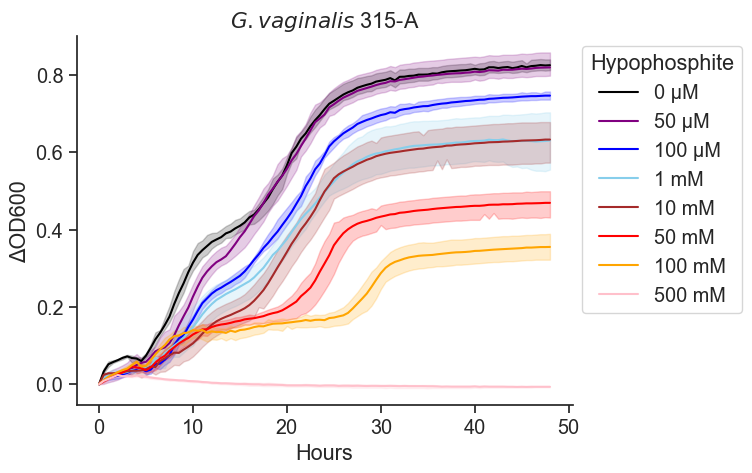

In [6]:
graphData = sliceDFBy(df11725, ['Strain'], [['G. vaginalis 315-A']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=palette)
plot.set(title='$\it{G. vaginalis}$ 315-A', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

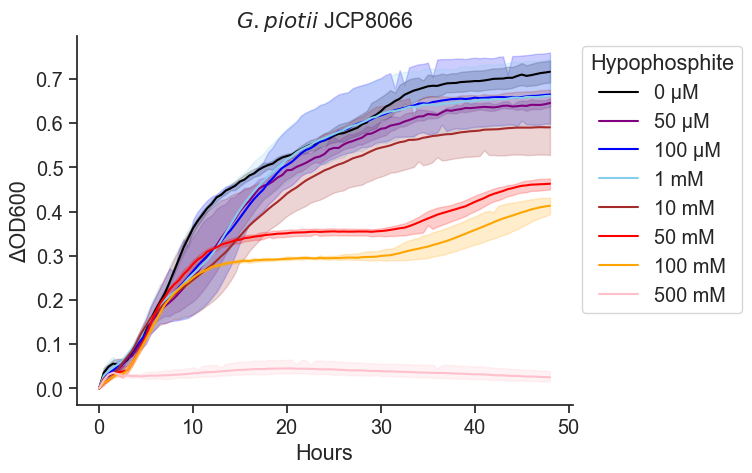

In [7]:
graphData = sliceDFBy(df11725, ['Strain'], [['G. piotii JCP8066']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=palette)
plot.set(title='$\it{G. piotii}$ JCP8066', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

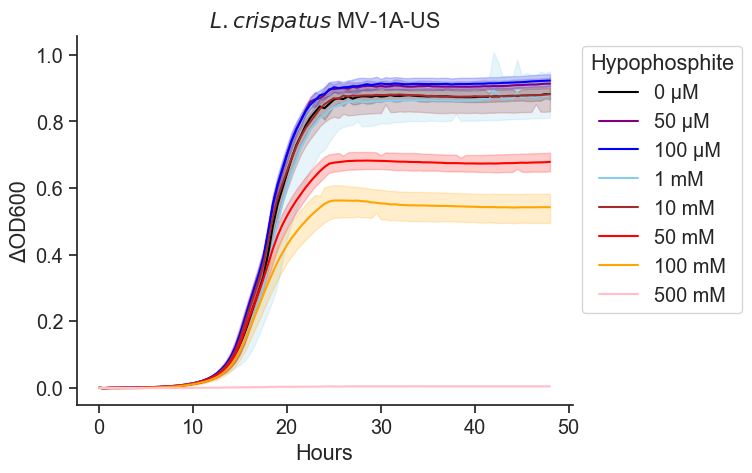

In [8]:
graphData = sliceDFBy(df11725, ['Strain'], [['L. crispatus MV-1A-US']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=palette)
plot.set(title='$\it{L. crispatus}$ MV-1A-US', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

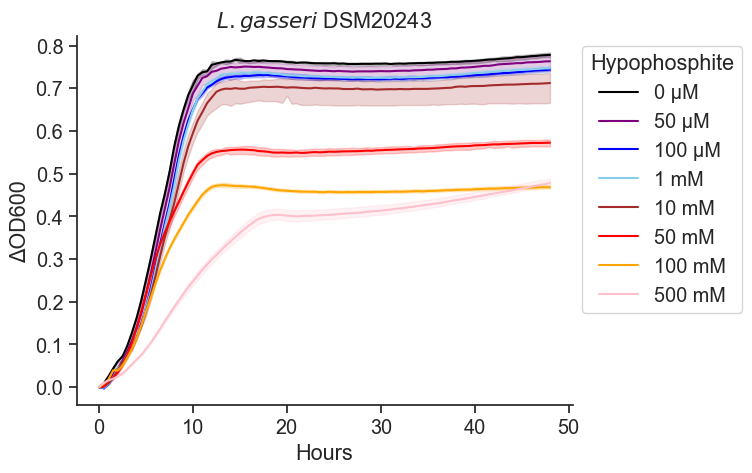

In [9]:
graphData = sliceDFBy(df11725, ['Strain'], [['L. gasseri DSM20243']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=palette)
plot.set(title='$\it{L. gasseri}$ DSM20243', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

In [10]:
formatePalette = palette = ['black', 'skyblue', 'red']

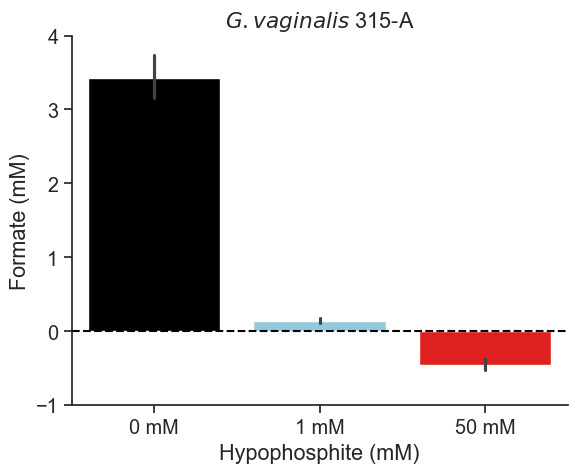

In [11]:
# Graph measured formate concentrations from this experiment
formate11925 = pd.read_csv(analysisPath.joinpath('1-19-25_formate_measurement.csv'))
plot = sns.barplot(data=formate11925, x='Hypophosphite (mM)', y='Formate (mM)', palette=formatePalette)
plt.axhline(0, ls='--', color='black')
plot.set(ylim=(-1, 4), title='$\it{G. vaginalis}$ 315-A')
sns.despine()

In [12]:
data12425 = pd.read_csv(analysisPath.joinpath('1-24-25_curves.csv'))
strains12425 = [
    ['L. crispatus ATCC33197', 'L. crispatus ATCC33197', 'L. crispatus ATCC33197', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['L. crispatus ATCC33197', 'L. crispatus ATCC33197', 'L. crispatus ATCC33197', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['L. crispatus ATCC33197', 'L. crispatus ATCC33197', 'L. crispatus ATCC33197', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['L. crispatus ATCC33197', 'L. crispatus ATCC33197', 'L. crispatus ATCC33197', 'L. iners DSM13335', 'L. iners DSM13335', 'L. iners DSM13335', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. jensenii DSM20557', 'L. jensenii DSM20557'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'S. vaginalis DSM16631', 'S. vaginalis DSM16631', 'S. vaginalis DSM16631'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'S. vaginalis DSM16631', 'S. vaginalis DSM16631', 'S. vaginalis DSM16631'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'S. vaginalis DSM16631', 'S. vaginalis DSM16631', 'S. vaginalis DSM16631'],
    ['G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis ATCC14018', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. vaginalis 315-A', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'S. vaginalis DSM16631', 'S. vaginalis DSM16631', 'S. vaginalis DSM16631'],
]
treatments12425 = [
    ['0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM'],
    ['1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM'],
    ['10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM'],
    ['25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM'],
    ['0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM'],
    ['1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM'],
    ['10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM'],
    ['25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM'],
]
df12425 = curveData2df(data12425, strains12425, treatments12425)
calculateDeltaOD(df12425)

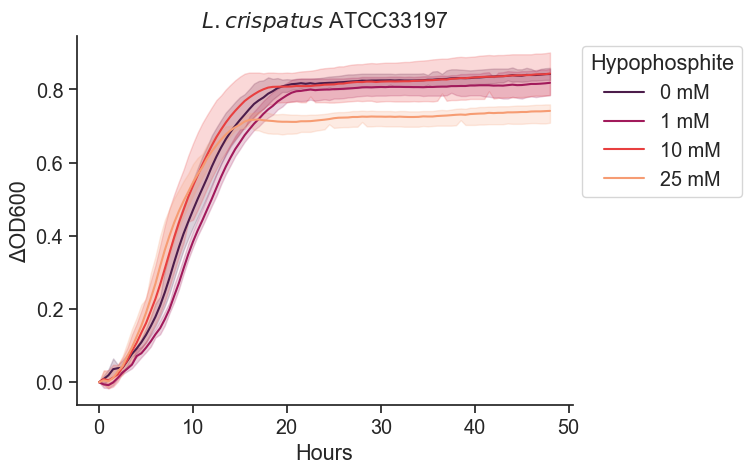

In [13]:
graphData = sliceDFBy(df12425, ['Strain'], [['L. crispatus ATCC33197']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{L. crispatus}$ ATCC33197', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Lcrispatus_atcc33197.png'))

In [14]:
aggregateEndpoints = getEndpointData(graphData, 48)

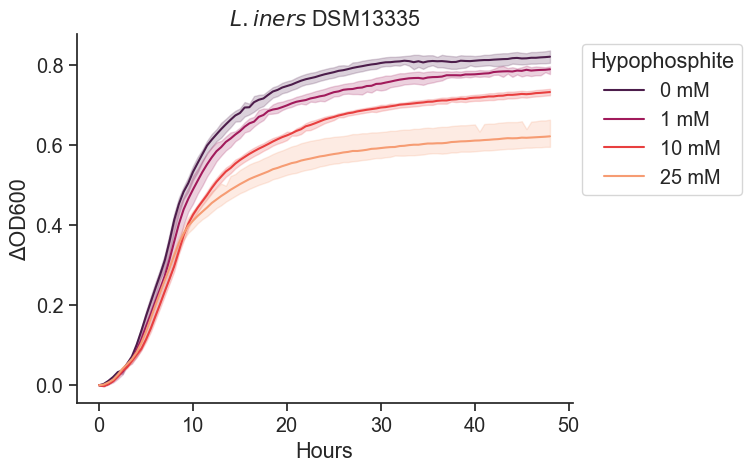

In [15]:
graphData = sliceDFBy(df12425, ['Strain'], [['L. iners DSM13335']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{L. iners}$ DSM13335', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Liners.png'))

In [16]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

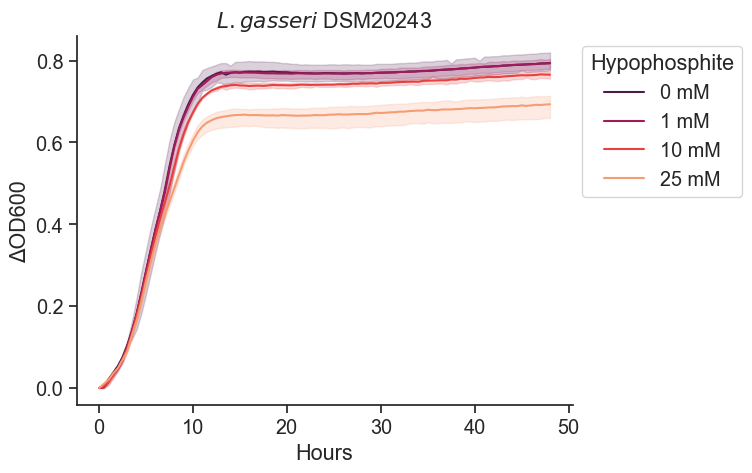

In [17]:
graphData = sliceDFBy(df12425, ['Strain'], [['L. gasseri DSM20243']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{L. gasseri}$ DSM20243', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Lgasseri_dsm20243.png'))

In [18]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

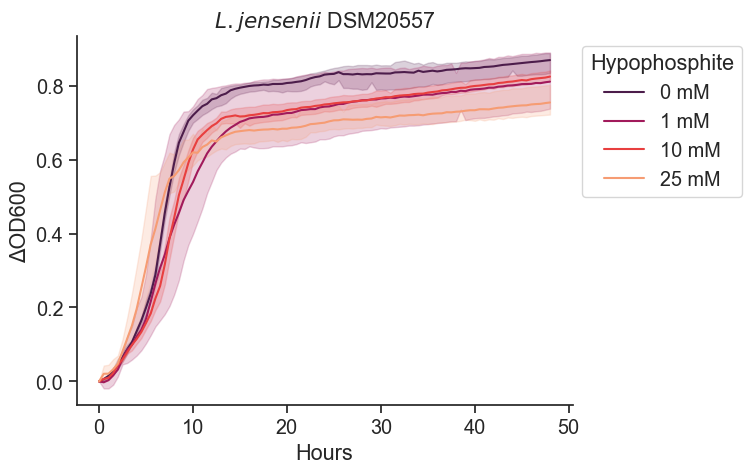

In [19]:
graphData = sliceDFBy(df12425, ['Strain'], [['L. jensenii DSM20557']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{L. jensenii}$ DSM20557', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Ljensenii_dsm20557.png'))

In [20]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

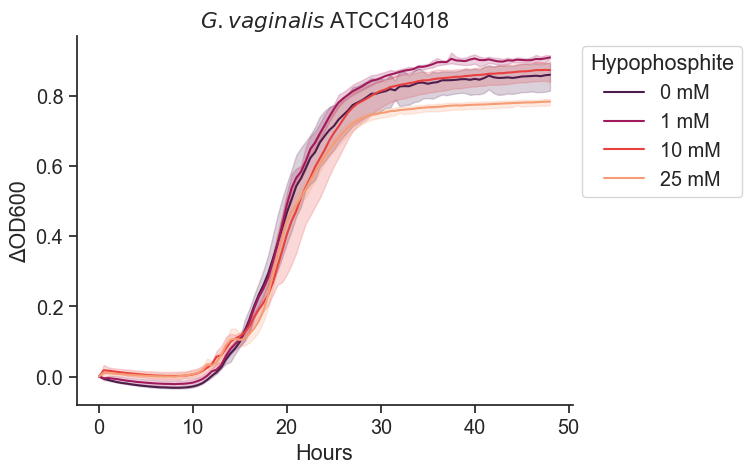

In [21]:
graphData = sliceDFBy(df12425, ['Strain'], [['G. vaginalis ATCC14018']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{G. vaginalis}$ ATCC14018', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Gvaginalis_atcc14018.png'))

In [22]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

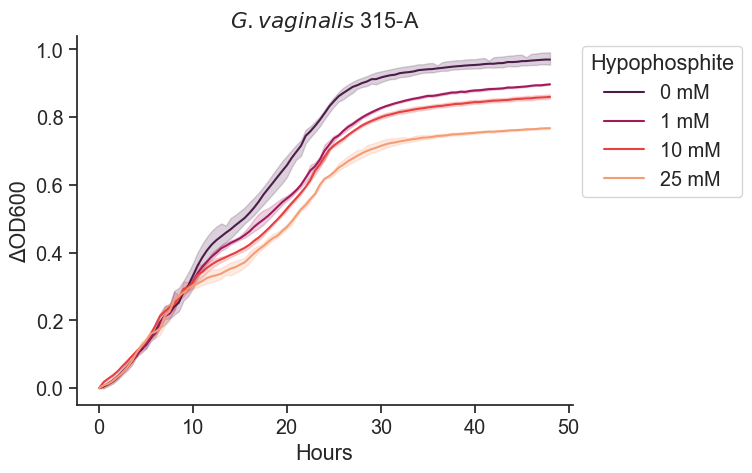

In [23]:
graphData = sliceDFBy(df12425, ['Strain'], [['G. vaginalis 315-A']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{G. vaginalis}$ 315-A', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Gvaginalis_315a.png'))

In [24]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

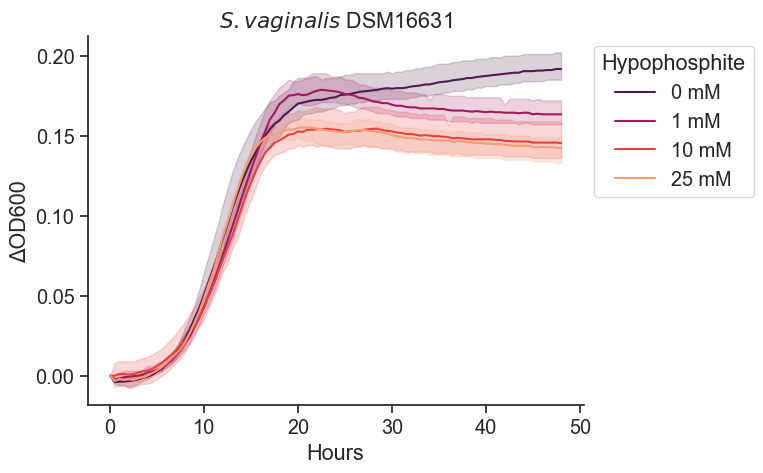

In [25]:
graphData = sliceDFBy(df12425, ['Strain'], [['S. vaginalis DSM16631']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{S. vaginalis}$ DSM16631', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Svaginalis_dsm16631.png'))

In [26]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

In [27]:
data12725 = pd.read_csv(analysisPath.joinpath('1-27-25_curves.csv'))
strains12725 = [
    ['G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US'],
    ['G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US'],
    ['G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US'],
    ['G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'G. swidsinskii CCUG72429', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'G. vaginalis ATCC14019', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US', 'L. crispatus MV-1A-US'],
    ['P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. mulieris DSM2710', 'M. mulieris DSM2710', 'M. mulieris DSM2710', 'A. nucleatus KA00274', 'A. nucleatus KA00274', 'A. nucleatus KA00274'],
    ['P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. mulieris DSM2710', 'M. mulieris DSM2710', 'M. mulieris DSM2710', 'A. nucleatus KA00274', 'A. nucleatus KA00274', 'A. nucleatus KA00274'],
    ['P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. mulieris DSM2710', 'M. mulieris DSM2710', 'M. mulieris DSM2710', 'A. nucleatus KA00274', 'A. nucleatus KA00274', 'A. nucleatus KA00274'],
    ['P. bivia DSM20514', 'P. bivia DSM20514', 'P. bivia DSM20514', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. mulieris DSM2710', 'M. mulieris DSM2710', 'M. mulieris DSM2710', 'A. nucleatus KA00274', 'A. nucleatus KA00274', 'A. nucleatus KA00274'],
]
treatments12725 = [
    ['0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM'],
    ['1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM'],
    ['10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM'],
    ['25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM'],
    ['0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM'],
    ['1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM'],
    ['10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM'],
    ['25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM'],
]
df12725 = curveData2df(data12725, strains12725, treatments12725)
calculateDeltaOD(df12725)

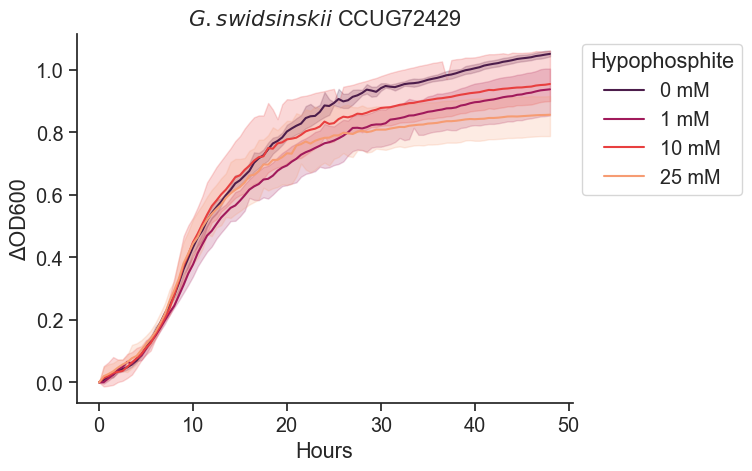

In [28]:
graphData = sliceDFBy(df12725, ['Strain'], [['G. swidsinskii CCUG72429']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{G. swidsinskii}$ CCUG72429', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Gswidsinskii_ccug72429.png'))

In [29]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

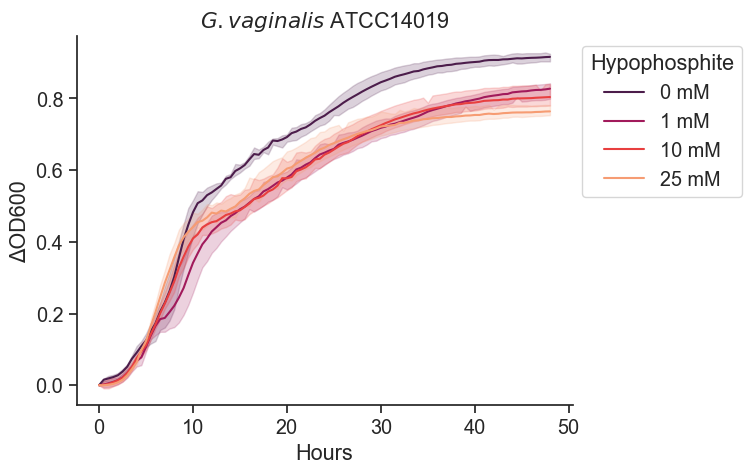

In [30]:
graphData = sliceDFBy(df12725, ['Strain'], [['G. vaginalis ATCC14019']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{G. vaginalis}$ ATCC14019', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Gvaginalis_atcc14019.png'))

In [31]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

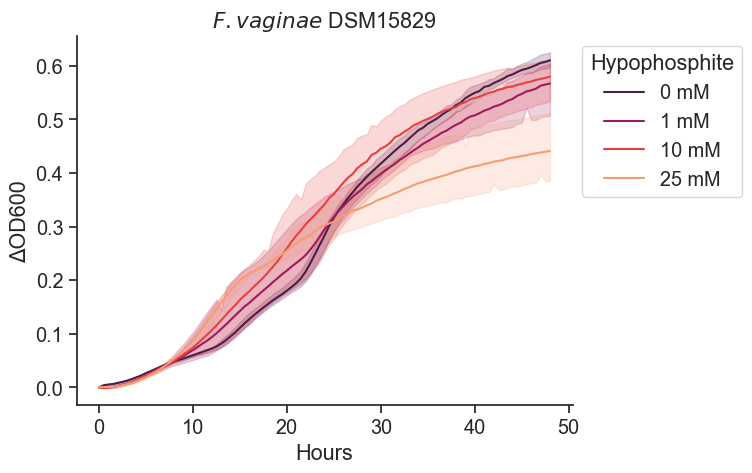

In [32]:
graphData = sliceDFBy(df12725, ['Strain'], [['F. vaginae DSM15829']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{F. vaginae}$ DSM15829', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

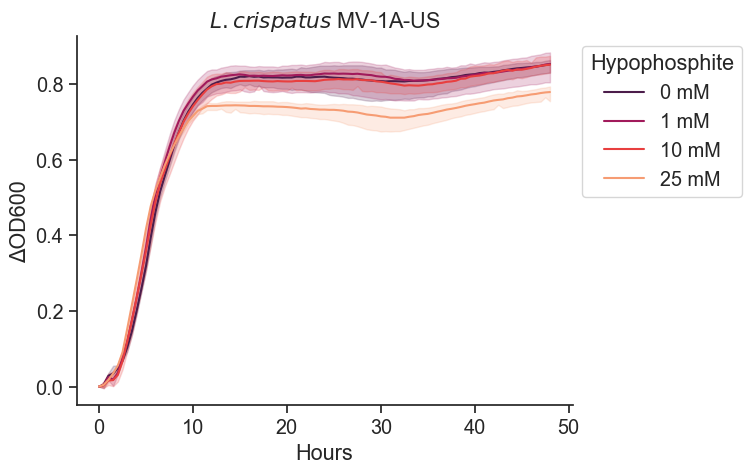

In [33]:
graphData = sliceDFBy(df12725, ['Strain'], [['L. crispatus MV-1A-US']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{L. crispatus}$ MV-1A-US', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Lcrispatus_mv1aus.png'))

In [34]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

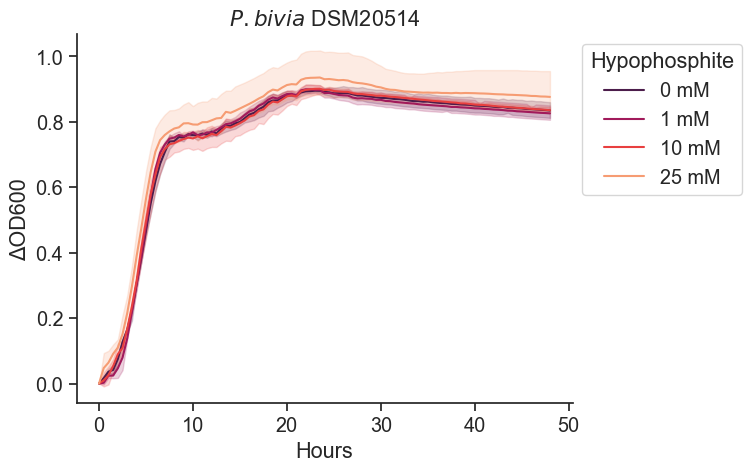

In [35]:
graphData = sliceDFBy(df12725, ['Strain'], [['P. bivia DSM20514']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{P. bivia}$ DSM20514', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Pbivia_dsm20514.png'))

In [36]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

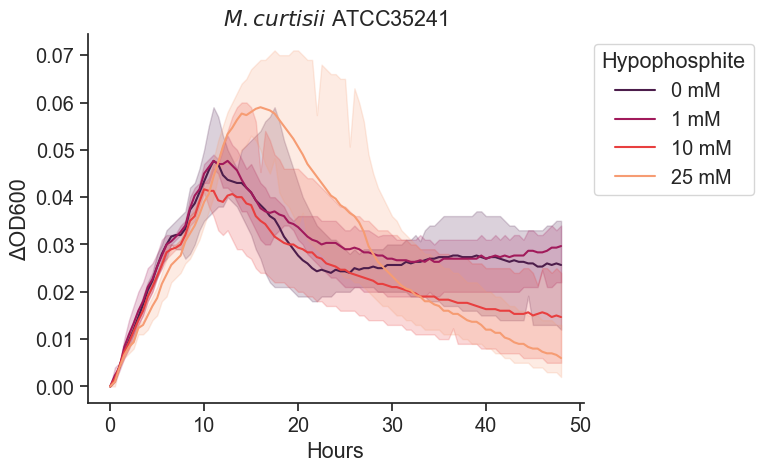

In [37]:
graphData = sliceDFBy(df12725, ['Strain'], [['M. curtisii ATCC35241']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{M. curtisii}$ ATCC35241', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

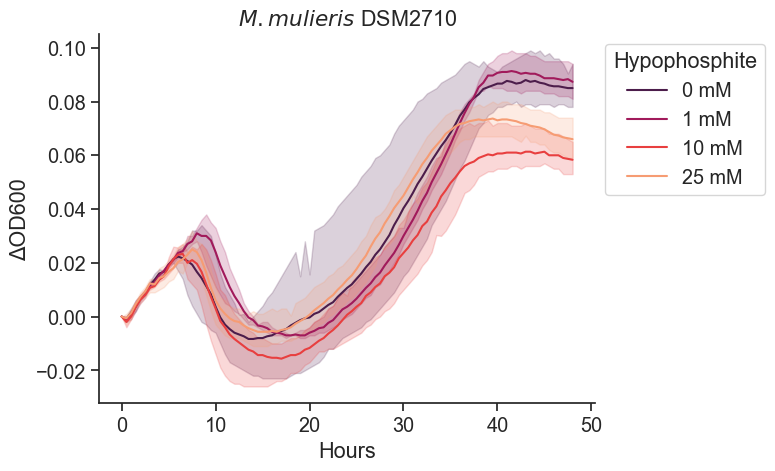

In [38]:
graphData = sliceDFBy(df12725, ['Strain'], [['M. mulieris DSM2710']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{M. mulieris}$ DSM2710', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Mmulieris_dsm2710.png'))

In [39]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

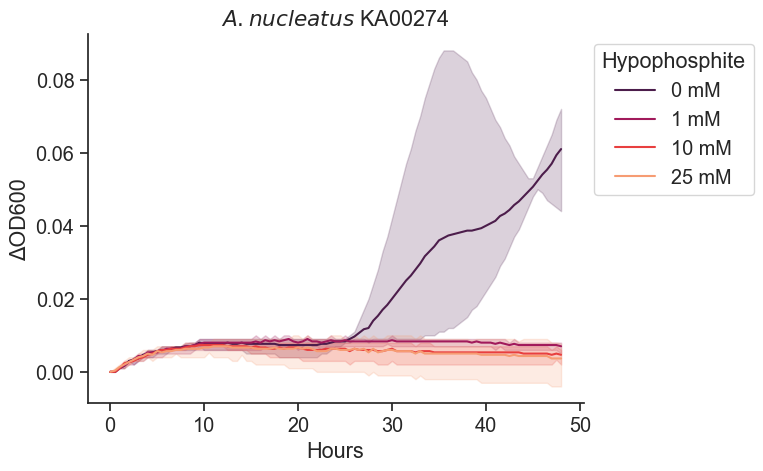

In [40]:
graphData = sliceDFBy(df12725, ['Strain'], [['A. nucleatus KA00274']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{A. nucleatus}$ KA00274', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Anucleatus_ka00274.png'))

In [41]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

In [42]:
data2825 = pd.read_csv(analysisPath.joinpath('2-8-25.csv'))
strains2825 = [
    ['G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'S. amnii DSM16630', 'S. amnii DSM16630', 'S. amnii DSM16630'],
    ['G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'S. amnii DSM16630', 'S. amnii DSM16630', 'S. amnii DSM16630'],
    ['G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'S. amnii DSM16630', 'S. amnii DSM16630', 'S. amnii DSM16630'],
    ['G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'S. amnii DSM16630', 'S. amnii DSM16630', 'S. amnii DSM16630'],
    ['M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. lornae 199-6', 'M. lornae 199-6', 'M. lornae 199-6', 'M. vaginalis BV3C16-1', 'M. vaginalis BV3C16-1', 'M. vaginalis BV3C16-1', 'A. indicium 610-J', 'A. indicium 610-J', 'A. indicium 610-J'],
    ['M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. lornae 199-6', 'M. lornae 199-6', 'M. lornae 199-6', 'M. vaginalis BV3C16-1', 'M. vaginalis BV3C16-1', 'M. vaginalis BV3C16-1', 'A. indicium 610-J', 'A. indicium 610-J', 'A. indicium 610-J'],
    ['M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. lornae 199-6', 'M. lornae 199-6', 'M. lornae 199-6', 'M. vaginalis BV3C16-1', 'M. vaginalis BV3C16-1', 'M. vaginalis BV3C16-1', 'A. indicium 610-J', 'A. indicium 610-J', 'A. indicium 610-J'],
    ['M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. curtisii ATCC35241', 'M. lornae 199-6', 'M. lornae 199-6', 'M. lornae 199-6', 'M. vaginalis BV3C16-1', 'M. vaginalis BV3C16-1', 'M. vaginalis BV3C16-1', 'A. indicium 610-J', 'A. indicium 610-J', 'A. indicium 610-J']
]
treatments2825 = [
    ['0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM'],
    ['1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM'],
    ['10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM'],
    ['25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM'],
    ['0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM'],
    ['1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM'],
    ['10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM'],
    ['25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM'],
]
df2825 = curveData2df(data2825, strains2825, treatments2825)
calculateDeltaOD(df2825)

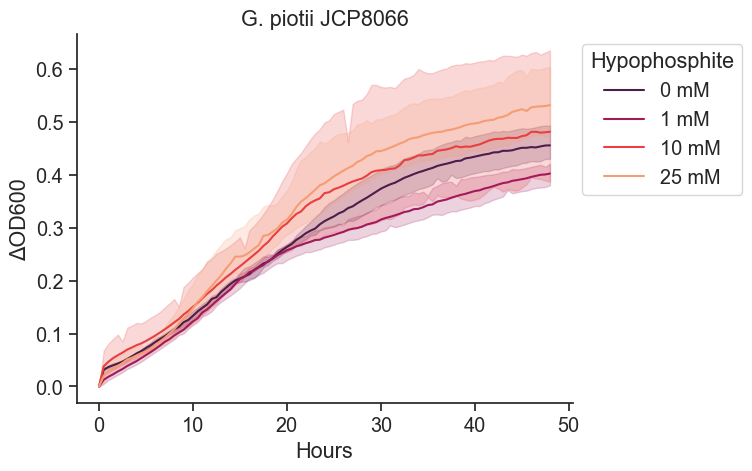

In [43]:
graphData = sliceDFBy(df2825, ['Strain'], [['G. piotii JCP8066']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='G. piotii JCP8066', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

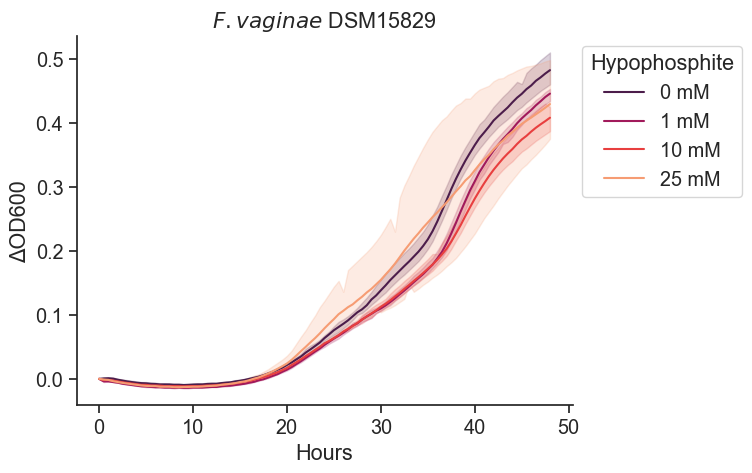

In [44]:
graphData = sliceDFBy(df2825, ['Strain'], [['F. vaginae DSM15829']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{F. vaginae}$ DSM15829', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Fvaginae_dsm15829.png'))

In [45]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

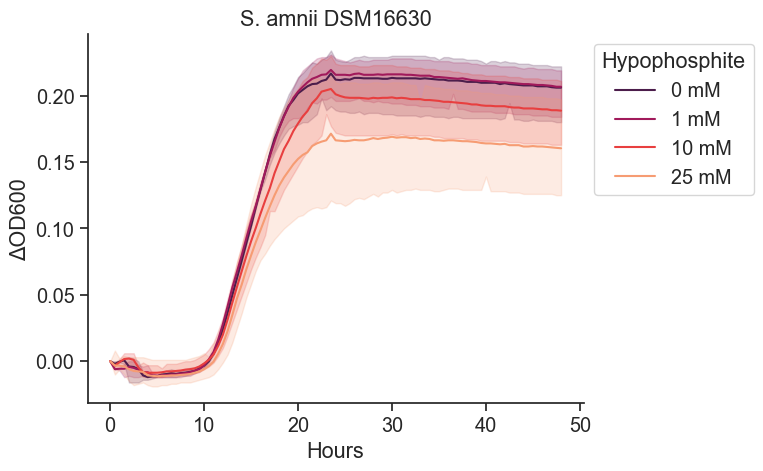

In [46]:
graphData = sliceDFBy(df2825, ['Strain'], [['S. amnii DSM16630']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='S. amnii DSM16630', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

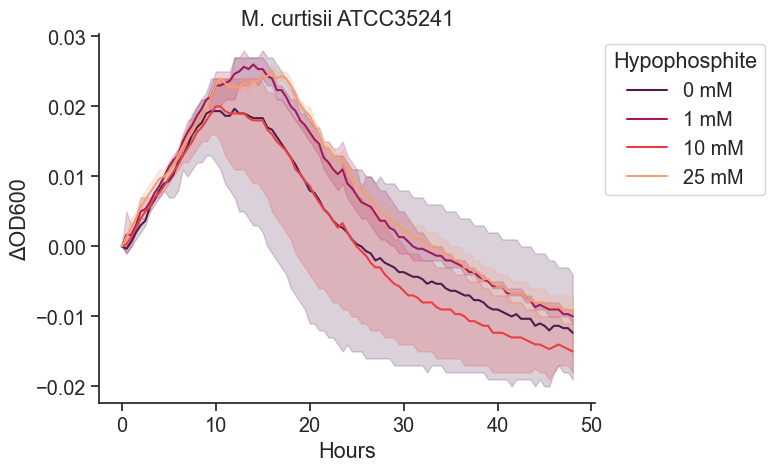

In [47]:
graphData = sliceDFBy(df2825, ['Strain'], [['M. curtisii ATCC35241']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='M. curtisii ATCC35241', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

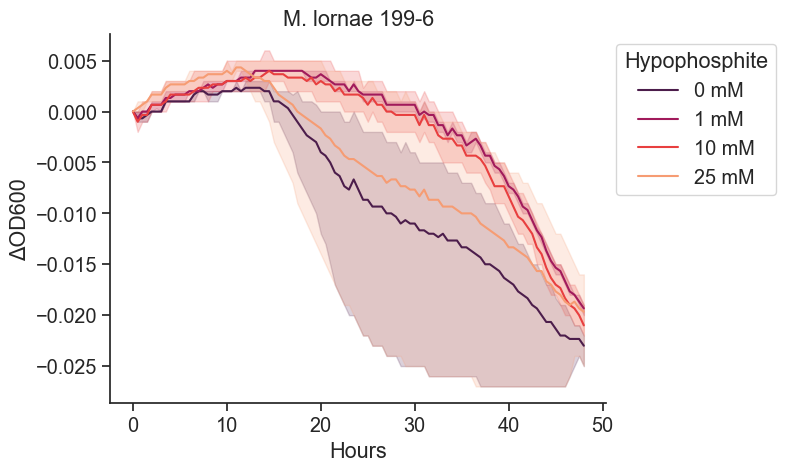

In [48]:
graphData = sliceDFBy(df2825, ['Strain'], [['M. lornae 199-6']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='M. lornae 199-6', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

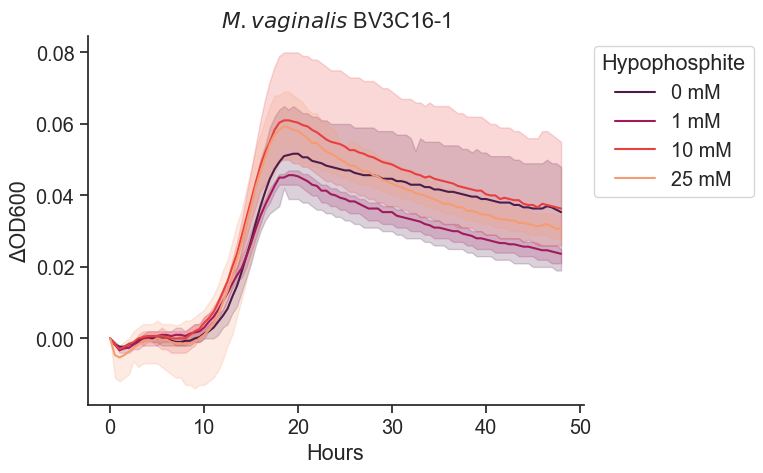

In [49]:
graphData = sliceDFBy(df2825, ['Strain'], [['M. vaginalis BV3C16-1']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{M. vaginalis}$ BV3C16-1', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

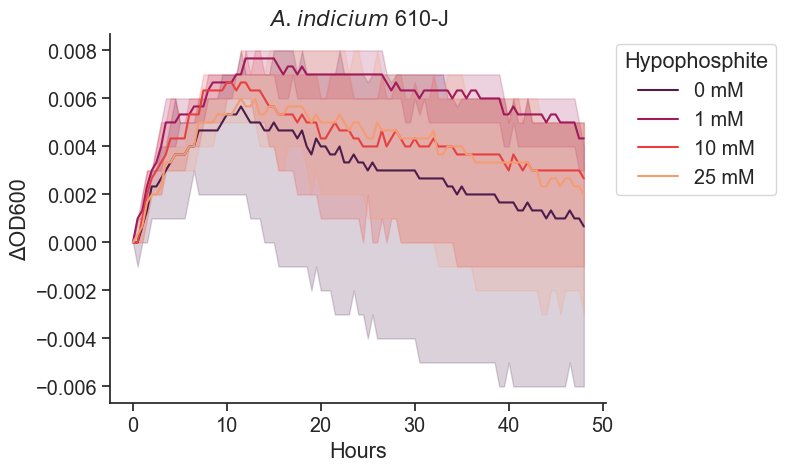

In [50]:
graphData = sliceDFBy(df2825, ['Strain'], [['A. indicium 610-J']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='$\it{A. indicium}$ 610-J', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

In [51]:
data21225 = pd.read_csv(analysisPath.joinpath('2-12-25.csv'))
strains21225 = [
    ['G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425'],
    ['G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425'],
    ['G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425'],
    ['G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii CCUG72427', 'G. piotii JCP8066', 'G. piotii JCP8066', 'G. piotii JCP8066', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'F. vaginae DSM15829', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425', 'G. leopoldii CCUG72425'],
    ['L. iners SPIN10541', 'L. iners SPIN10541', 'L. iners SPIN10541', 'L. gasseri 224-1', 'L. gasseri 224-1', 'L. gasseri 224-1', 'L. jensenii 208-1', 'L. jensenii 208-1', 'L. jensenii 208-1', '', '', ''],
    ['L. iners SPIN10541', 'L. iners SPIN10541', 'L. iners SPIN10541', 'L. gasseri 224-1', 'L. gasseri 224-1', 'L. gasseri 224-1', 'L. jensenii 208-1', 'L. jensenii 208-1', 'L. jensenii 208-1', '', '', ''],
    ['L. iners SPIN10541', 'L. iners SPIN10541', 'L. iners SPIN10541', 'L. gasseri 224-1', 'L. gasseri 224-1', 'L. gasseri 224-1', 'L. jensenii 208-1', 'L. jensenii 208-1', 'L. jensenii 208-1', '', '', ''],
    ['L. iners SPIN10541', 'L. iners SPIN10541', 'L. iners SPIN10541', 'L. gasseri 224-1', 'L. gasseri 224-1', 'L. gasseri 224-1', 'L. jensenii 208-1', 'L. jensenii 208-1', 'L. jensenii 208-1', '', '', '']
]
treatments21225 = [
    ['0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM'],
    ['1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM'],
    ['10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM'],
    ['25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM'],
    ['0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM', '0 mM'],
    ['1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM', '1 mM'],
    ['10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM', '10 mM'],
    ['25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM', '25 mM'],
]
df21225 = curveData2df(data21225, strains21225, treatments21225)
calculateDeltaOD(df21225)

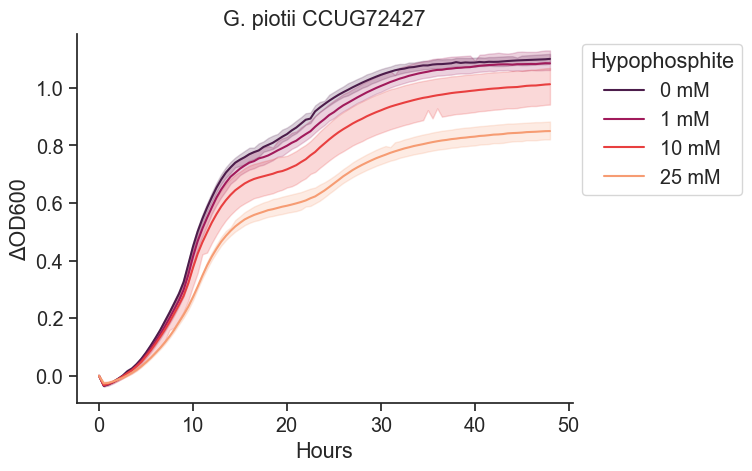

In [52]:
graphData = sliceDFBy(df21225, ['Strain'], [['G. piotii CCUG72427']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='G. piotii CCUG72427', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

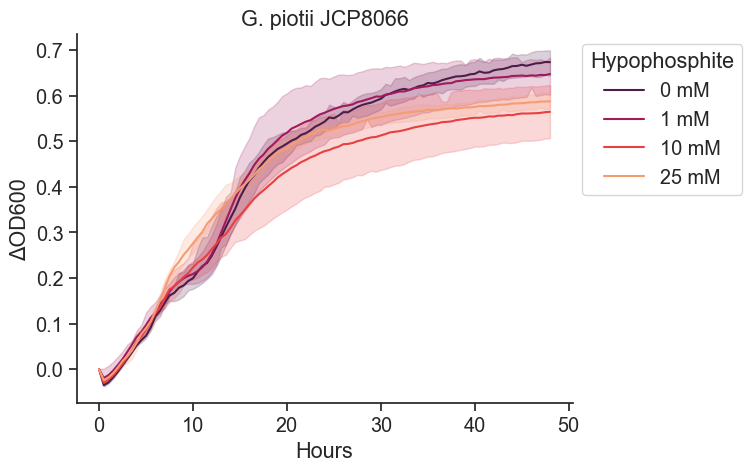

In [66]:
graphData = sliceDFBy(df21225, ['Strain'], [['G. piotii JCP8066']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='G. piotii JCP8066', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Gpiotii_jcp8066.png'))

In [54]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

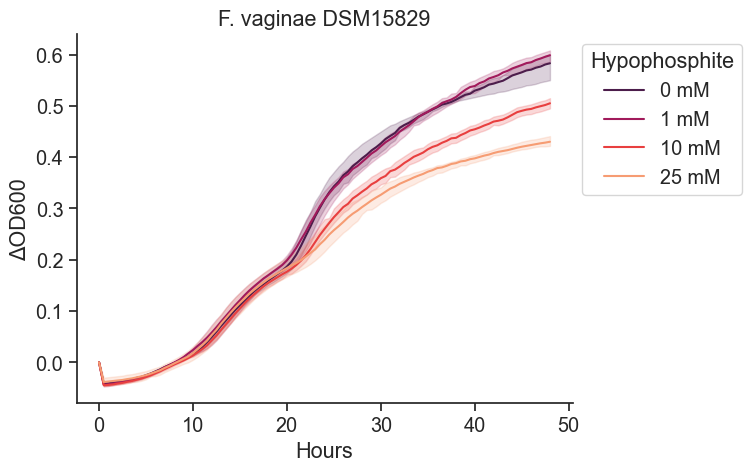

In [65]:
graphData = sliceDFBy(df21225, ['Strain'], [['F. vaginae DSM15829']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='F. vaginae DSM15829', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))
saveFig(plot, figurePath.joinpath('Fvaginae_dsm15829'))

In [56]:
aggregateEndpoints = pd.concat([aggregateEndpoints, getEndpointData(graphData, 48)], axis=0)

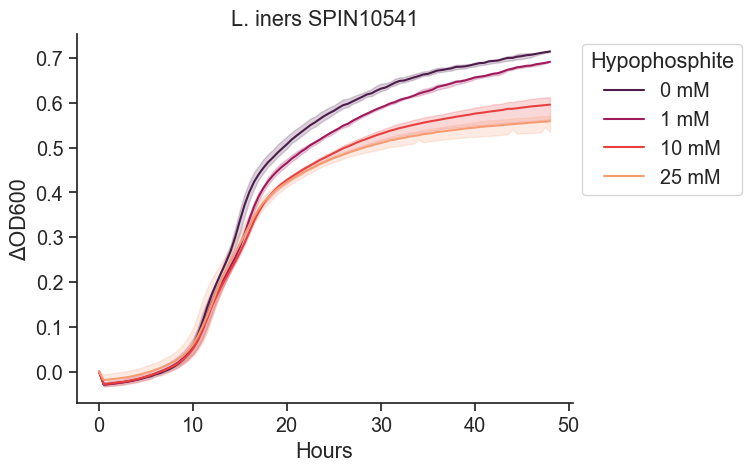

In [57]:
graphData = sliceDFBy(df21225, ['Strain'], [['L. iners SPIN10541']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='L. iners SPIN10541', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

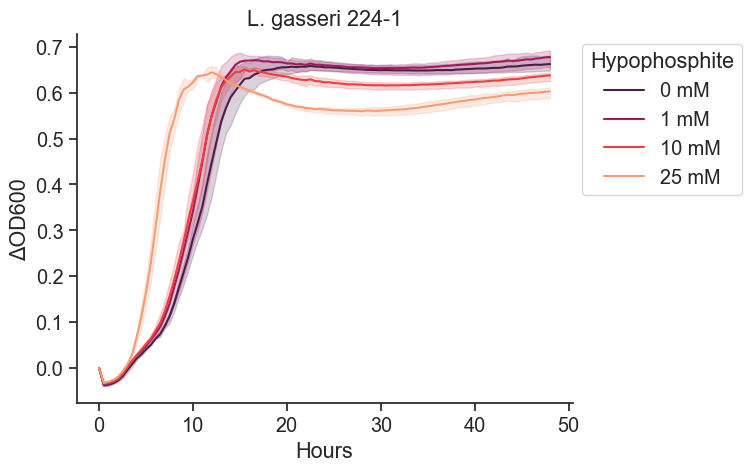

In [58]:
graphData = sliceDFBy(df21225, ['Strain'], [['L. gasseri 224-1']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='L. gasseri 224-1', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

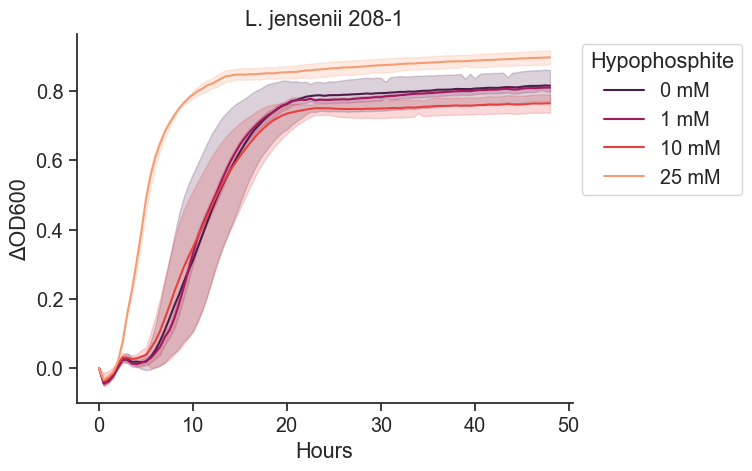

In [59]:
graphData = sliceDFBy(df21225, ['Strain'], [['L. jensenii 208-1']])
plot = sns.lineplot(data=graphData, x='Hours', y='Delta OD600', hue='Hypophosphite', palette=sns.color_palette('rocket', 4))
plot.set(title='L. jensenii 208-1', ylabel='ΔOD600')
sns.despine()
sns.move_legend(plot, 'upper left', bbox_to_anchor=(1, 1))

In [60]:
# Graph endpoints data for all these growth curves as a percent of growth on 0mM Hypophosphite
# First, calculate the average Delta OD600 for each isolate at 0mM
avg0 = {} #key=strain name, value=average delta OD600 @ 0mM hypophosphite
zeroDeltas = []
for index, row in aggregateEndpoints.iterrows():
    if row['Hypophosphite'] == '0 mM':
        zeroDeltas.append(row['Delta OD600'])
    if len(zeroDeltas) == 3:
        avg0[row['Strain']] = mean(zeroDeltas)
        zeroDeltas = []

In [61]:
# Calculate % growth for each value
percents = []
for index, row in aggregateEndpoints.iterrows():
    percents.append((row['Delta OD600'] / avg0[row['Strain']]) * 100)

In [62]:
aggregateEndpoints['Percent Growth'] = percents

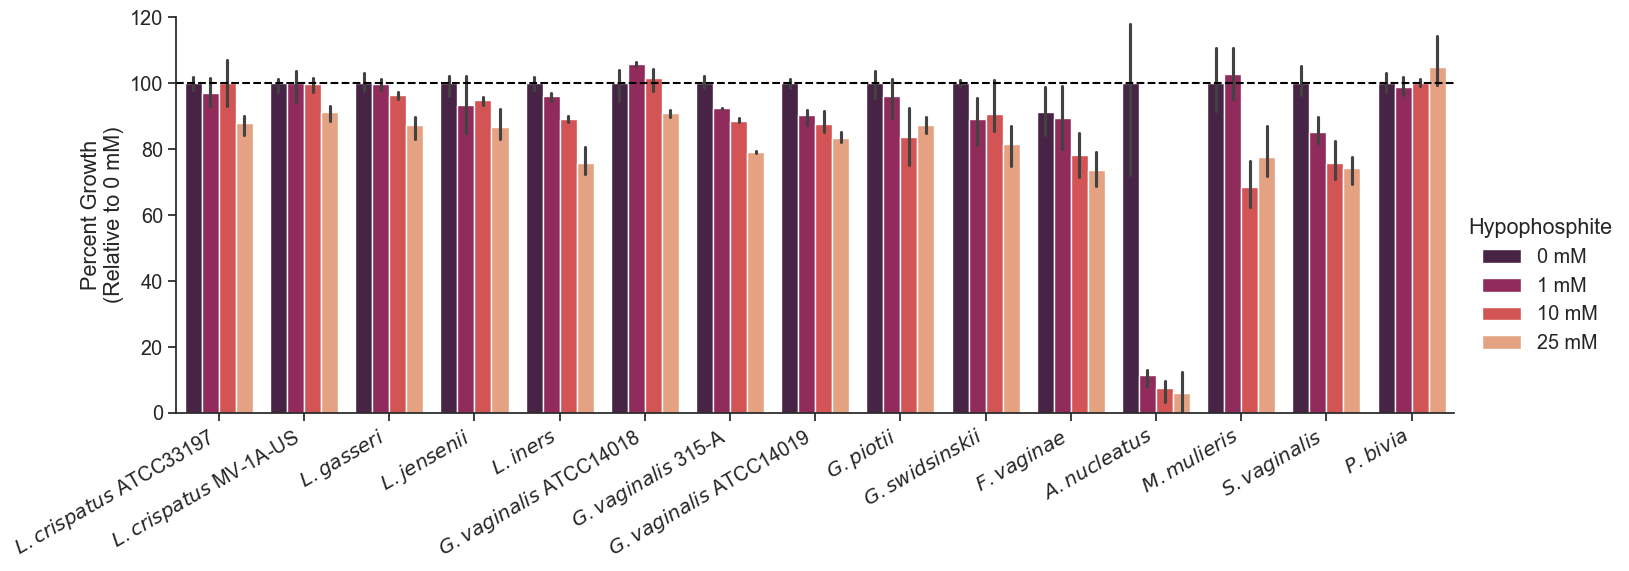

In [63]:
plotOrder = order=['L. crispatus ATCC33197', 'L. crispatus MV-1A-US', 'L. gasseri DSM20243', 'L. jensenii DSM20557', 'L. iners DSM13335', 'G. vaginalis ATCC14018', 'G. vaginalis 315-A', 'G. vaginalis ATCC14019', 'G. piotii JCP8066', 'G. swidsinskii CCUG72429', 'F. vaginae DSM15829', 'A. nucleatus KA00274', 'M. mulieris DSM2710', 'S. vaginalis DSM16631', 'P. bivia DSM20514']
plot = sns.catplot(data=aggregateEndpoints, kind='bar', x='Strain', y='Percent Growth', hue='Hypophosphite', aspect=2.8, order=plotOrder, palette=sns.color_palette('rocket', 4))
plot.set(xlabel='', ylabel='Percent Growth\n(Relative to 0 mM)', ylim=(0, 120))
plot.set_xticklabels(['$\it{L. crispatus}$ ATCC33197', '$\it{L. crispatus}$ MV-1A-US', '$\it{L. gasseri}$', '$\it{L. jensenii}$', '$\it{L. iners}$', '$\it{G. vaginalis}$ ATCC14018', '$\it{G. vaginalis}$ 315-A', '$\it{G. vaginalis}$ ATCC14019', '$\it{G. piotii}$', '$\it{G. swidsinskii}$', '$\it{F. vaginae}$', '$\it{A. nucleatus}$', '$\it{M. mulieris}$', '$\it{S. vaginalis}$', '$\it{P. bivia}$'], rotation=30, ha='right')
plt.axhline(100, ls='--', color='black')
plot.savefig(figurePath.joinpath('2-14-25_aggregate.png'), bbox_inches='tight', dpi=300)

In [64]:
aggregateEndpoints.to_csv(analysisPath.joinpath('endpoints.csv'))

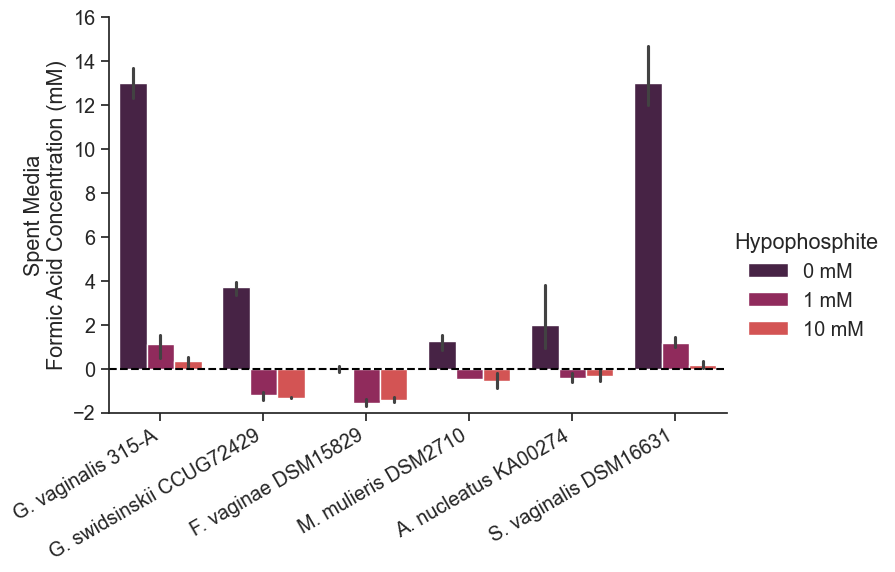

In [64]:
# Plot Formic acid concentrations in spent media from some of these experiments
formateDF = pd.read_csv(analysisPath.joinpath('1-31-25_formate_measurement.csv'))
plotOrder = ['G. vaginalis 315-A', 'G. swidsinskii CCUG72429', 'F. vaginae DSM15829', 'M. mulieris DSM2710', 'A. nucleatus KA00274', 'S. vaginalis DSM16631']
plot = sns.catplot(data=formateDF, kind='bar', x='Strain', y='Formate (mM)', hue='Hypophosphite', aspect=1.5, order=plotOrder, palette=sns.color_palette('rocket', 4)[0:3])
plot.set(xlabel='', ylabel='Spent Media\nFormic Acid Concentration (mM)', ylim=(-2, 16))
plot.set_xticklabels(rotation=30, ha='right')#['$\it{L. crispatus}$', '$\it{L. iners}$', '$\it{L. gasseri}$', '$\it{L. jensenii}$', '$\it{G. vaginalis}$ ATCC14018', '$\it{G. vaginalis}$ UPII 315-A', '$\it{G. piotii}$', '$\it{G. swidsinskii}$', '$\it{G. leopoldii}$', '$\it{F. vaginae}$', '$\it{A. indicium}$', '$\it{A. nucleatus}$', '$\it{M. lornae}$', '$\it{M. vaginalis}$', '$\it{M. curtisii}$', '$\it{M. mulieris}$', '$\it{S. vaginalis}$', '$\it{P. bivia}$', 'ELVB'], rotation=30, ha='right')
plt.axhline(0, ls='--', color='black')
plot.savefig(figurePath.joinpath('1-31-25_formate.png'), bbox_inches='tight', dpi=300)

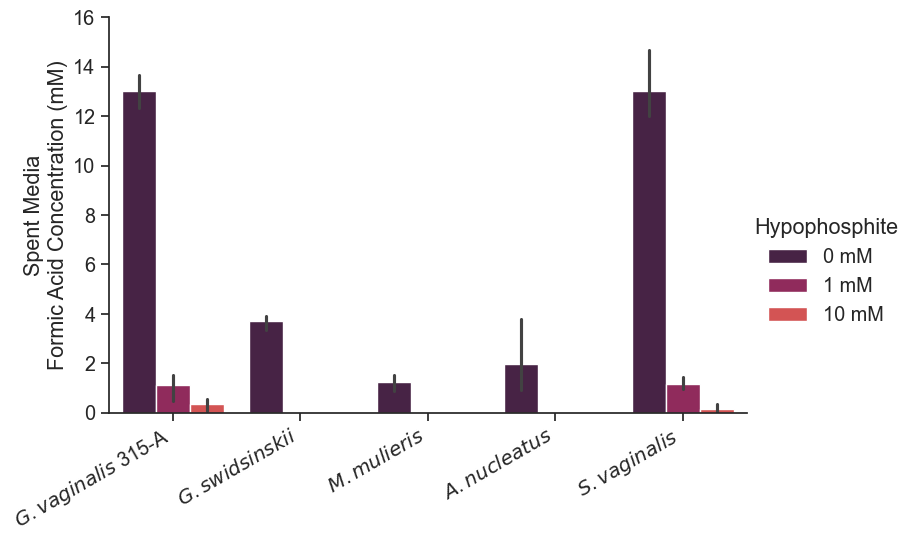

In [74]:
# Same plot as above but for publication
formateDF = pd.read_csv(analysisPath.joinpath('1-31-25_formate_measurement.csv'))
plotOrder = ['G. vaginalis 315-A', 'G. swidsinskii CCUG72429', 'M. mulieris DSM2710', 'A. nucleatus KA00274', 'S. vaginalis DSM16631']
plot = sns.catplot(data=formateDF, kind='bar', x='Strain', y='Formate (mM)', hue='Hypophosphite', aspect=1.5, order=plotOrder, palette=sns.color_palette('rocket', 4)[0:3])
plot.set(xlabel='', ylabel='Spent Media\nFormic Acid Concentration (mM)', ylim=(0, 16))
plot.set_xticklabels(['$\it{G. vaginalis}$ 315-A', '$\it{G. swidsinskii}$', '$\it{M. mulieris}$', '$\it{A. nucleatus}$', '$\it{S. vaginalis}$'], rotation=30, ha='right')
plot.savefig(figurePath.joinpath('1-31-25_formate_pub.png'), bbox_inches='tight', dpi=300)